# 11 - Climatological ESP forecasting

## Extended Streamflow Prediction (ESP) forecasts from climatological time series

This notebook shows how to perform a climatological Extended Streamflow Prediction (ESP) forecast, using historical weather as a proxy for future weather.

The general idea is to initialize the state of the hydrological model to represent current conditions, but instead of using weather forecasts to predict future flows, we run the model with observed, historical weather series from past years. So for example if we have 30 years of weather observations, we get 30 different forecasts. The accuracy of this forecast ensemble can then be evaluated by different probabilistic metrics.

In [1]:
import datetime as dt

from matplotlib import pyplot as plt
from ravenpy.models import GR4JCN, HRU
from ravenpy.utilities import forecasting
from ravenpy.utilities.testdata import get_file

## Run the model simulations

Here we set model parameters somewhat arbitrarily, but you can set the parameters to the calibrated parameters as seen in the "06_Raven_calibration" notebook we previously encountered. We can then specify the start date for the climatological ESP simulations and run the simulations.

We also need to choose the forecast date. Each forecast will start with the same day and month. For example, sep-09-2005 will compare the climatology using all sep-09ths from the dataset.

In [2]:
# Get the selected watershed's time series. You can use your own time-series for your catchment by replacing this line
# to the name of your input file.
ts = get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc")

# Here we add the physiographic data needed by Raven models.
hru = GR4JCN.LandHRU(area=4523.5, longitude=-72.55, latitude=48.39, elevation=300.0)

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE', 'HBVEC' and 'BLENDED'.
model = "GR4JCN"

# Since we've used GR4JCN, we need to provide that model's parameters. You should replace with your calibrated parameters!
params = (0.529, -3.396, 407.29, 1.072, 16.9, 0.947)

### Issuing the forecast

Here we launch the code that will perform the forecast. Depending on the number of years in the historical dataset and the forecast duration, it might take a while to return a forecast result.

In [9]:
%%capture --no-display
# Adding this to avoid spamming warning messages for overwriting files.
# Forecast parameters:
f_date = dt.datetime(2005, 9, 13)  # Choose the forecast date.
f_duration = 10  # Length in days of the climatological ESP forecast

# Simulate the climatological ESP:
q_sims = forecasting.perform_climatology_esp(
    model_name=model,
    forecast_date=f_date,
    forecast_duration=f_duration,
    params=params,
    hrus=[
        hru,
    ],
    ts=ts,
)

We can now inspect and graph the resulting climatological ESP:

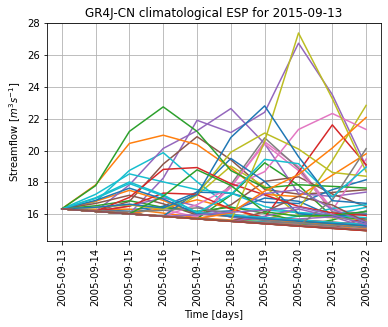

In [4]:
# Plot the resulting climatological ESP:
plt.plot(q_sims.time, q_sims.T)
plt.xlabel("Time [days]")
plt.ylabel("Streamflow $[m^3s^{-1}]$")
plt.title("GR4J-CN climatological ESP for 2015-09-13")
plt.xticks(rotation=90)
plt.grid("on")
plt.show()

## Compute the forecast scores

There are different metric to evaluate the performance of forecasts. As an example, here we are computing the CRPS metric, using the [xskillscore](https://xskillscore.readthedocs.io/en/stable/) library included in PAVICS-Hydro.

In [5]:
import xarray as xr
import xskillscore as xs

# Align time axes
q_obs, q_sims = xr.align(xr.open_dataset(ts).qobs, q_sims, join="inner")

# Compute the Continuous Ranked Probability Score
xs.crps_ensemble(q_obs, q_sims, dim="time")

<xarray.DataArray ()>
array(7.00144818)
Coordinates:
    basin_name  object 'sub_001'

## Performing a climatology ESP hindcast 
In this section, we make the hindcasts for each initialization date. Here we will extract ESP forecasts for a given calendar date for the years in "included_years" as hindcast dates. Each ESP hindcast uses all available data in the `ts` dataset, so in this case we will have 56/57 members for each hindcast initialization depending on the date that we start on. The "hindcasts" dataset contains all of the flow data from the ESP hindcasts for the initialization dates. The `q_obs` dataset contains all q_obs in the timeseries: Climpred will sort it all out during its processing. Note that the format of these datasets is tailor-made to be used in climpred, and thus has specific dimension names.


This is a slimmed down example of how we would run an ESP forecast over multiple years to assess the skill of such a forecast. 

In [10]:
%%capture --no-display
# Adding this to avoid spamming warning messages for overwriting files.
hindcasts, q_obs = forecasting.make_ESP_hindcast_dataset(
    model_name=model,
    forecast_date=f_date,
    included_years=list(range(1957, 1959)),
    forecast_duration=f_duration,
    ts=ts,
    hrus=(hru,),
    params=params,
)

## Evaluate the forecast using different metrics
Once we have the correctly formatted datasets, Make the hindcast object for climpred

These three functions respectively compute the rank histogram, the CRPS and the reliability for the set of initialized dates (i.e. forecast issue dates, here 1 day per year at the same calendar day).

In [11]:
# Once we have the correctly formatted datasets, Make the hindcast object for climpred
hindcast_object = forecasting.make_climpred_hindcast_object(hindcasts, q_obs)


# This function is used to convert to binary to see if yes/no forecast is larger than observations
def pos(x):
    return x > 0  # Check for binary outcome


# Rank histogram verification metric
rank_histo_verif = hindcast_object.verify(
    metric="rank_histogram",
    comparison="m2o",
    dim=["member", "init"],
    alignment="same_inits",
)
# CRPS verification metric
crps_verif = hindcast_object.verify(
    metric="crps",
    comparison="m2o",
    dim=["member", "init"],
    alignment="same_inits",
)
# Reliability verification metric
reliability_verif = hindcast_object.verify(
    metric="reliability",
    comparison="m2o",
    dim=["member", "init"],
    alignment="same_inits",
    logical=pos,
)

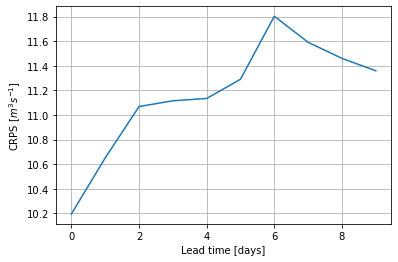

In [12]:
plt.plot(crps_verif.flow)
plt.xlabel("Lead time [days]")
plt.ylabel("CRPS $[m^3s^{-1}]$")
plt.grid("on")
plt.show()